# Make hex Difference Maps

In [26]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '12'

In [5]:
pd.set_option('display.max_columns', None)

## Load in the Data:

In [27]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))
lakes_tuol = pickle.load(open('../../../data/misc/lakes_tuolumne.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))
streamlines_tuol = pickle.load(open('../../../data/misc/streamlines_tuol.pkl', 'rb'))

hetch = pickle.load(open('../../../data/misc/hetch_hetchy.pkl', 'rb'))

tuol_reverse = pickle.load(open('../../../data/misc/tuol_reverse.pkl', 'rb'))

streamlines_tuol = pickle.load(open('../../../data/misc/streamlines_tuol.pkl', 'rb'))

In [28]:
hillshade = rxr.open_rasterio('../../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_100m_hillshade.tif', masked=True).squeeze()
#chm = rxr.open_rasterio('../../../data/lidar/tuolumne/chm/USCATB20140827_chm_3p0m_ma_100m.tif', masked=True).squeeze()
dtm = rxr.open_rasterio('../../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_100m.tif', masked=True).squeeze()

In [11]:
#lakes = gpd.read_file('../../../data/misc/California_Lakes.geojson')
#hetch = lakes[lakes['NAME']=='Hetch Hetchy Reservoir']
#hetch = hetch.to_crs('EPSG:32611')

# # Save the Hetch Hetchy file

# out_fn = '../../../data/misc/hetch_hetchy.pkl'

# with open(out_fn, 'wb') as f:
#     pickle.dump(hetch, f)

In [12]:
# # Save the combined geodataframe of the two cdec sites

# out_fn = '../../../data/misc/tuol_reverse.pkl'

# with open(out_fn, 'wb') as f:
#     pickle.dump(tuol_reverse, f)

In [10]:
# from: https://data.cnra.ca.gov/dataset/nhd-major-features

# streamlines = gpd.read_file('../../../data/misc/nhd_major_rivers_and_creeks/Major_Rivers_and_Creeks.shp')
#streamlines = streamlines.to_crs('epsg:32611')
#streamlines_tuol = gpd.clip(streamlines, outline_gdf)

# # Save the file

# out_fn = '../../../data/misc/streamlines_tuol.pkl'

# with open(out_fn, 'wb') as f:
#     pickle.dump(streamlines_tuol, f)

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [29]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [30]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [31]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

### Create the hex map using code from GDA 2021

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

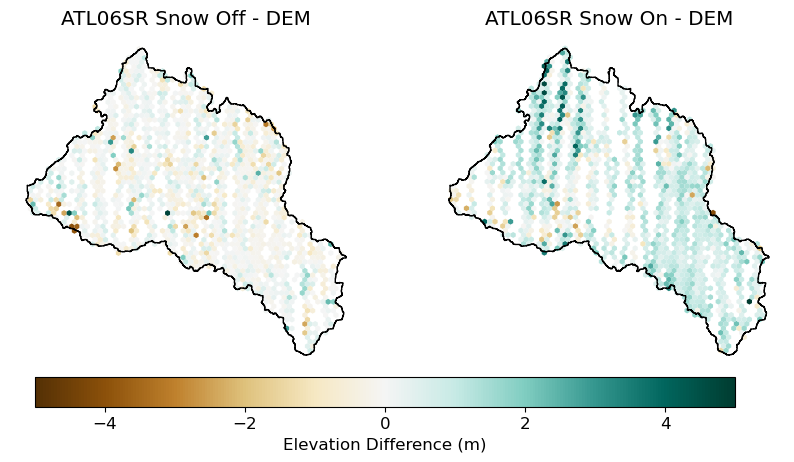

In [214]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

hb_off = ax[0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')

hb_on = ax[1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')

outline_gdf.plot(ax=ax[0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1], facecolor='none', edgecolor='k')

for axis in ax:
    axis.set_axis_off()

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.25, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0].set_title('ATL06SR Snow Off - DEM')
ax[1].set_title('ATL06SR Snow On - DEM')

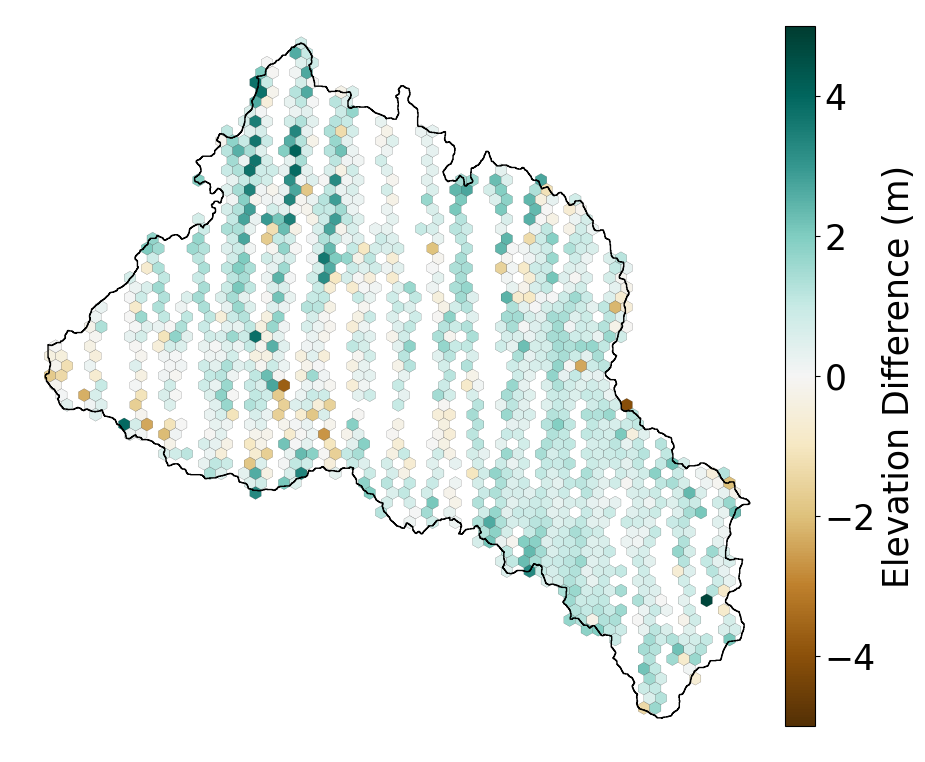

In [20]:
plt.rcParams['font.size'] = '25'

fig, ax = plt.subplots(figsize=(10,10))

#outline_gdf.plot(ax=ax, facecolor='mistyrose', edgecolor='none')

hb_on = ax.hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='k', linewidth=.1)

cbar_ax2 = fig.add_axes([0.9, 0.15, 0.03, 0.7])
plt.colorbar(hb_on, cax=cbar_ax2, label='Elevation Difference (m)', orientation='vertical')

outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

ax.set_axis_off()

#plt.tight_layout()

#plt.savefig('../../figures/polished/snow_on_hexmap.jpeg', dpi=300)

In [100]:
cmap(0)

(0.32941176470588235, 0.18823529411764706, 0.0196078431372549, 1.0)

In [102]:
cmap(1000)

(0.0, 0.23529411764705882, 0.18823529411764706, 1.0)

In [116]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks/figure_production


Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

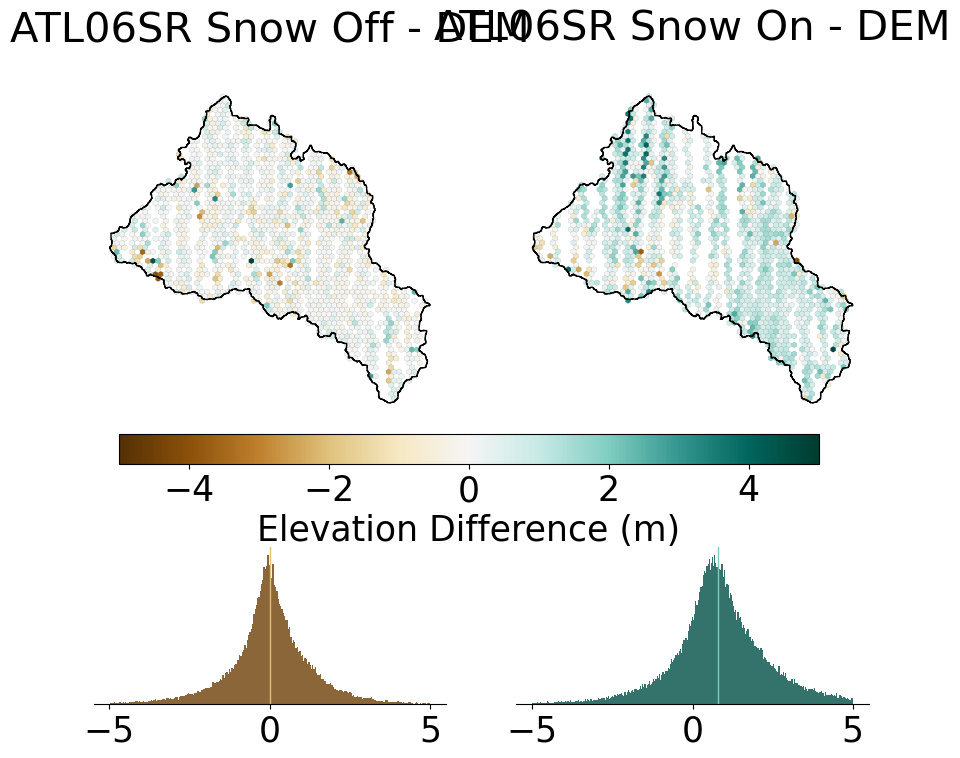

In [23]:
# add histograms to difference plots
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [1,1]})

hb_off = ax[0,0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='k', linewidth=.05)
ax[0,0].set_axis_off()

hb_on = ax[0,1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='k', linewidth=.05, vmin=-5, vmax=5)
ax[0,1].set_axis_off()

outline_gdf.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[0,1], facecolor='none', edgecolor='k')

ax[1,0].hist(atl06sr_gdf[inner_snowoff_idx]['diff_plus'], color=cmap(norm(-4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowoff_idx]))), alpha=0.8)
ax[1,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-2)), linewidth=1)
#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax[1,0].spines.right.set_visible(False)
ax[1,0].spines.top.set_visible(False)
ax[1,0].spines.left.set_visible(False)
ax[1,0].axes.yaxis.set_visible(False)

ax[1,1].hist(atl06sr_gdf[inner_snowon_idx]['diff_plus'], color=cmap(norm(4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowon_idx]))), alpha=0.8)
ax[1,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(2)), linewidth=1)
#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.top.set_visible(False)
ax[1,1].spines.left.set_visible(False)
ax[1,1].axes.yaxis.set_visible(False)

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0,0].set_title('ATL06SR Snow Off - DEM')
ax[0,1].set_title('ATL06SR Snow On - DEM')

#plt.savefig('../../figures/polished/difference_map_hist.jpeg', dpi=500)

## Add another Row with Hillshade and other characteristics

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_13692/828227034.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


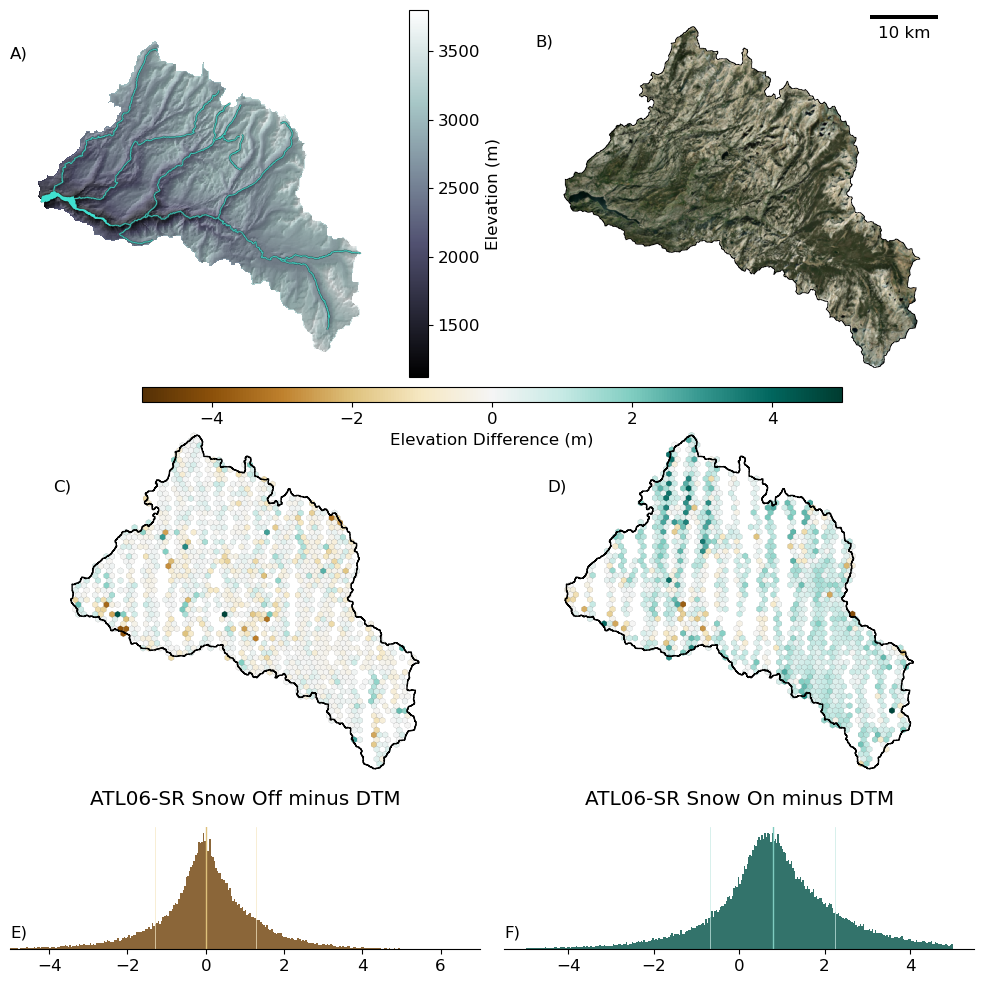

In [30]:
basemap = cx.providers.Esri.WorldImagery

# add histograms to difference plots
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplots(3,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

c = dtm.plot(cmap='bone', ax=ax[0,0], add_colorbar=True, cbar_kwargs={'label':'Elevation (m)'})
#chm.plot(cmap='Greens', ax=ax[0,0], add_colorbar=True, vmin=0, vmax=20, cbar_kwargs={'label':'Canopy Height (m)','shrink':0.9}, alpha=0.8)
hillshade.plot(cmap='Greys', ax=ax[0,0], add_colorbar=False, alpha=0.3)
streamlines_tuol.plot(ax=ax[0,0], color='darkslategrey', linewidth=1.5, alpha=0.8, zorder=1)
streamlines_tuol.plot(ax=ax[0,0], color='turquoise', linewidth=0.75, alpha=0.8, zorder=5)
hetch.plot(ax=ax[0,0], color='turquoise',zorder=10)
ax[0,0].set_xlim(250000, 310000)
ax[0,0].set_ylim(4178000, 4232000)
ax[0,0].set_axis_off()
ax[0,0].set_title('')
ax[0,0].annotate(text='A)', xy=(0,0.9), xycoords='axes fraction')

#ax[0,1].set_axis_off()
ax[0,1].set_title('')
#c.set_label('Canopy Height(m)')
#ig.colorbar(c, label = 'Canopy Height (m)')

ax[0,1].add_artist(ScaleBar(1))
outline_gdf.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
cx.add_basemap(ax[0,1], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=12)
tuol_reverse.plot(ax=ax[0,1], facecolor='white')
ax[0,1].set_xlim(250000, 310000)
ax[0,1].set_ylim(4178000, 4232000)
ax[0,1].axes.xaxis.set_ticks([])
ax[0,1].axes.yaxis.set_ticks([])
ax[0,1].annotate(text='B)', xy=(0,0.9), xycoords='axes fraction')

hb_off = ax[1,0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='k', linewidth=.05)
ax[1,0].set_axis_off()
ax[1,0].annotate(text='C)', xy=(0,0.8), xycoords='axes fraction')

hb_on = ax[1,1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='k', linewidth=.05, vmin=-5, vmax=5)
ax[1,1].set_axis_off()
ax[1,1].annotate(text='D)', xy=(0,0.8), xycoords='axes fraction')

outline_gdf.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1,1], facecolor='none', edgecolor='k')

ax[2,0].hist(atl06sr_gdf[inner_snowoff_idx]['diff_plus'], color=cmap(norm(-4.5)),\
            bins=252, alpha=0.8)
ax[2,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-2)), linewidth=1)
#add lines for the standard deviation
ax[2,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
                np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
ax[2,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) - 
                np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax[2,0].spines.right.set_visible(False)
ax[2,0].spines.top.set_visible(False)
ax[2,0].spines.left.set_visible(False)
ax[2,0].axes.yaxis.set_visible(False)
ax[2,0].set_xlim(-5,7)
ax[2,0].annotate(text='E)', xy=(0,0.1), xycoords='axes fraction')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='std')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='median')

ax[2,1].hist(atl06sr_gdf[inner_snowon_idx]['diff_plus'], color=cmap(norm(4.5)),\
            bins=290, alpha=0.8)
ax[2,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(2)), linewidth=1)
ax[2,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) + 
                np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
ax[2,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) -
                np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.top.set_visible(False)
ax[2,1].spines.left.set_visible(False)
ax[2,1].axes.yaxis.set_visible(False)
ax[2,1].annotate(text='F)', xy=(0,0.1), xycoords='axes fraction')

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.59, 0.7, 0.015])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[1,0].set_title('ATL06-SR Snow Off minus DTM', y=0, pad=-14)
ax[1,1].set_title('ATL06-SR Snow On minus DTM', y=0, pad=-14)

for ax in [ax[0,0], ax[0,1]]:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
    
plt.tight_layout()
plt.savefig('../../figures/polished/difference_map_hist_w-hillshade.jpeg', dpi=500)

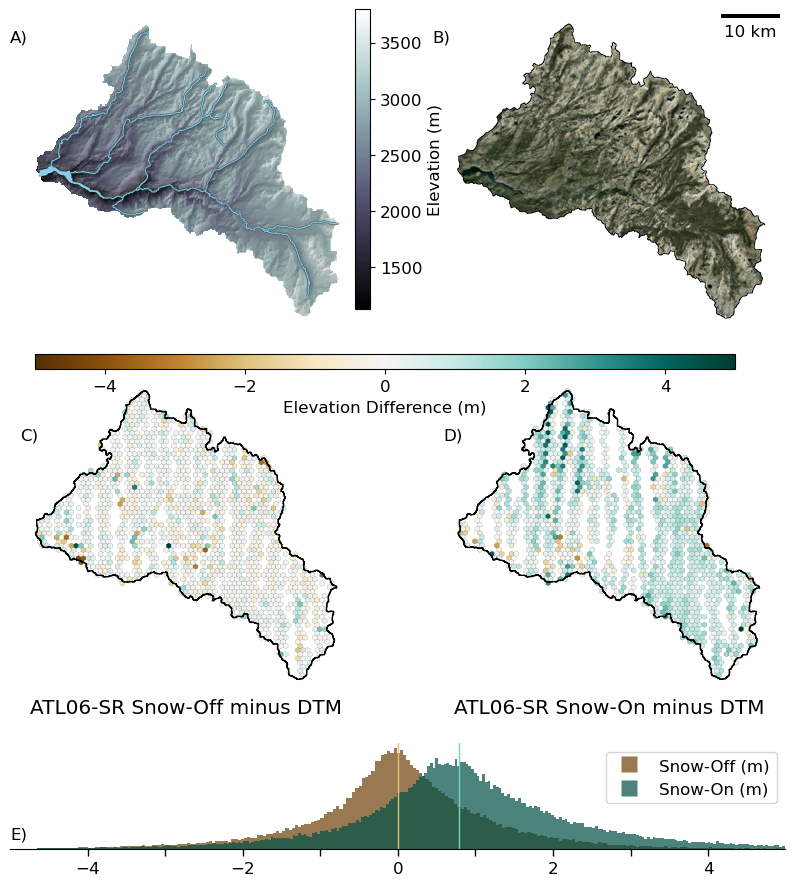

In [48]:
# With combined histograms

basemap = cx.providers.Esri.WorldImagery

# add histograms to difference plots
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplot_mosaic([['a', 'b'],
                             ['c', 'd'],
                             ['e', 'e']], figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

c = dtm.plot(cmap='bone', ax=ax['a'], add_colorbar=False) # , cbar_kwargs={'label':'Elevation (m)'}
#chm.plot(cmap='Greens', ax=ax[0,0], add_colorbar=True, vmin=0, vmax=20, cbar_kwargs={'label':'Canopy Height (m)','shrink':0.9}, alpha=0.8)
hillshade.plot(cmap='Greys', ax=ax['a'], add_colorbar=False, alpha=0.3)
streamlines_tuol.plot(ax=ax['a'], color='darkslategrey', linewidth=1.5, alpha=0.8, zorder=1)
streamlines_tuol.plot(ax=ax['a'], color='skyblue', linewidth=0.75, alpha=1, zorder=5)
hetch.plot(ax=ax['a'], color='skyblue', alpha=1,zorder=10)
ax['a'].set_xlim(250000, 310000)
ax['a'].set_ylim(4178000, 4232000)
ax['a'].set_axis_off()
ax['a'].set_title('')
ax['a'].annotate(text='A)', xy=(0,0.9), xycoords='axes fraction')

#ax[0,1].set_axis_off()
ax['b'].set_title('')
#c.set_label('Canopy Height(m)')
#ig.colorbar(c, label = 'Canopy Height (m)')

ax['b'].add_artist(ScaleBar(1))
outline_gdf.plot(ax=ax['b'], facecolor='none', edgecolor='k')
cx.add_basemap(ax['b'], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=12)
tuol_reverse.plot(ax=ax['b'], facecolor='white')
ax['b'].set_xlim(250000, 310000)
ax['b'].set_ylim(4178000, 4232000)
ax['b'].axes.xaxis.set_ticks([])
ax['b'].axes.yaxis.set_ticks([])
ax['b'].annotate(text='B)', xy=(0,0.9), xycoords='axes fraction')

hb_off = ax['c'].hexbin(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0].geometry.x, 
               atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0].geometry.y, 
               C=atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='k', linewidth=.075)
ax['c'].set_axis_off()
ax['c'].annotate(text='C)', xy=(0,0.8), xycoords='axes fraction')

hb_on = ax['d'].hexbin(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1].geometry.x, 
               atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1].geometry.y, 
               C=atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='k', linewidth=.075, vmin=-5, vmax=5)
ax['d'].set_axis_off()
ax['d'].annotate(text='D)', xy=(0,0.8), xycoords='axes fraction')

outline_gdf.plot(ax=ax['c'], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax['d'], facecolor='none', edgecolor='k')

ax['e'].hist(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], color=cmap(norm(-4.5)),\
            bins=250, alpha=0.7)
ax['e'].axvline(x = np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic']), c=cmap(norm(-2)), linewidth=1)
ax['e'].tick_params('both', length=5, width=1, which='major')
ax['e'].tick_params('both', length=5, width=1, which='minor')
#add lines for the standard deviation
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) - 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)

#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax['e'].spines.right.set_visible(False)
ax['e'].spines.top.set_visible(False)
ax['e'].spines.left.set_visible(False)
ax['e'].axes.yaxis.set_visible(False)
ax['e'].set_xlim(-5,4.99)
ax['e'].annotate(text='E)', xy=(0,0.1), xycoords='axes fraction')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='std')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='median')

ax['e'].hist(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], color=cmap(norm(4.5)),\
            bins=290, alpha=0.7)
ax['e'].axvline(x = np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic']), c=cmap(norm(2)), linewidth=1)
#ax['e'].set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])

#Add minor ticks between the labels
minor_locator = AutoMinorLocator(2)
ax['e'].xaxis.set_minor_locator(minor_locator)

# MAKE A LEGEND
custom = [Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=cmap(norm(-4.5), alpha=0.7), linestyle='None'),
        Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=cmap(norm(4.5), alpha=0.7), linestyle='None')
          ]
custom_labels = ['Snow-Off (m)', 'Snow-On (m)']

ax['e'].legend(custom, custom_labels, loc='upper right')

# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) -
#                 np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)

#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
# ax[2,1].spines.right.set_visible(False)
# ax[2,1].spines.top.set_visible(False)
# ax[2,1].spines.left.set_visible(False)
# ax[2,1].axes.yaxis.set_visible(False)
# ax[2,1].annotate(text='F)', xy=(0,0.1), xycoords='axes fraction')

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.95) #0.8
cbar_ax = fig.add_axes([0.15, 0.59, 0.7, 0.015])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')
cbar_ax2 = fig.add_axes([0.47, 0.65, 0.015, 0.3]) #.46
plt.colorbar(c, cax=cbar_ax2, label='Elevation (m)', orientation='vertical')

#plt.tight_layout()
ax['c'].set_title('ATL06-SR Snow-Off minus DTM', y=0, pad=-14)
ax['d'].set_title('ATL06-SR Snow-On minus DTM', y=0, pad=-14)

for ax in [ax['a'], ax['b']]:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        
    

#plt.tight_layout()
plt.savefig('../../figures/polished/difference_map_hist_w-hillshade.jpeg', dpi=500)

In [38]:
atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'].size

62896

In [36]:
np.sqrt(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus'].size)

250.79074943067576

In [37]:
np.sqrt(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus'].size)

290.0879177077184

In [158]:
(np.max(atl06sr_gdf.geometry.x) - np.min(atl06sr_gdf.geometry.x)) / 60

855.1625690177219

In [160]:
np.max(atl06sr_gdf.geometry.x) - np.min(atl06sr_gdf.geometry.x)

51309.75414106331

In [54]:
np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'])

0.7871588775478813

In [50]:
scipy.stats.skew(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], nan_policy='omit')

0.01757830814338745

In [52]:
scipy.stats.skewtest(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], nan_policy='omit')

SkewtestResult(statistic=1.7998288102306337, pvalue=0.07188767330960434)

In [51]:
scipy.stats.skew(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], nan_policy='omit')

0.02266663322042124

In [53]:
scipy.stats.skewtest(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], nan_policy='omit')

SkewtestResult(statistic=2.6842562771371936, pvalue=0.007269136162246597)

In [21]:
import statistics
statistics.mode(atl06sr_gdf[inner_snowon_idx]['diff_plus_bicubic'])

1.2348278537738224

In [23]:
atl06sr_gdf.head(2)

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy,snow_presence,lidar_z,difference,bicubic_lidar_z,sampling_dif,difference_bicubic,site,acqdate,n,diff_plus,diff_plus_bicubic,zscore,ASO_snowon,ASO_snowon_date,ASO_snowon_bic
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (269304.074 4196719.705),288,2018.788969,15,0,2501.669922,-0.292738,2501.695326,-0.025404,-0.318142,tuolumne,2018-10-15,919,-0.178201,-0.215620,-0.052818,NaN,NaN,NaN
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (269302.684 4196739.709),288,2018.788969,15,0,2501.169922,-0.053049,2501.249151,-0.079229,-0.132278,tuolumne,2018-10-15,919,0.061488,-0.029756,-0.035698,NaN,NaN,NaN


In [24]:
atl06sr_gdf[inner_snowoff_idx]['n_fit_photons'].describe()

count    62896.000000
mean        50.167101
std         63.512609
min         10.000000
25%         17.000000
50%         30.000000
75%         55.000000
max       1070.000000
Name: n_fit_photons, dtype: float64

In [25]:
atl06sr_gdf[inner_snowon_idx]['n_fit_photons'].describe()

count    83581.000000
mean       126.255357
std        106.438937
min         10.000000
25%         39.000000
50%         97.000000
75%        188.000000
max       1340.000000
Name: n_fit_photons, dtype: float64

In [21]:
atl06sr_gdf.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
# should i report the iqr instead of std for consistency with table 1? more resistant to outliers.

In [221]:
from scipy import stats

def iqr2(x):
    IQR = stats.iqr(x, interpolation = 'midpoint')
    return IQR

In [222]:
iqr2(atl06sr_gdf[inner_snowon_idx]['diff_plus'])

1.5704840071178978

In [223]:
iqr2(atl06sr_gdf[inner_snowoff_idx]['diff_plus'])

1.2430893767943871

## Try out a kernel density estimator to check the spread of measurements

In [78]:
import seaborn as sns

(array([240000., 260000., 280000., 300000., 320000.]),
 [Text(240000.0, 0, '240000'),
  Text(260000.0, 0, '260000'),
  Text(280000.0, 0, '280000'),
  Text(300000.0, 0, '300000'),
  Text(320000.0, 0, '320000')])

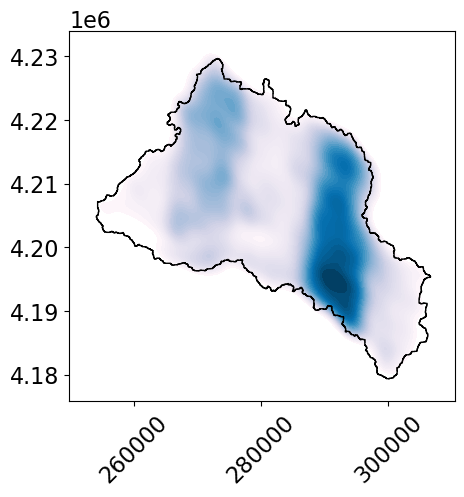

In [84]:
f, ax = plt.subplots()

kde = sns.kdeplot(data='diff_plus', x=atl06sr_gdf.geometry.x, y=atl06sr_gdf.geometry.y, fill=True, legend=True, cmap='PuBu', levels=50, ax=ax)

#plt.colorbar(kde, label='Point Density')

outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

plt.xticks(rotation=45)
#plt.title('GLAS Kernel Density Estimator')